In [2]:
import pandas as pd

In [229]:
X = pd.DataFrame({'city':['tokyo', None, 'london', 'seattle', 'san francisco', 'tokyo'], 
                  'boolean':['yes', 'no', None, 'no', 'no', 'yes'], 
                  'ordinal_column':['somewhat like', 'like', 'somewhat like', 'like', 'somewhat like', 'dislike'], 
                  'quantitative_column':[1, 11, -.5, 10, None, 20]})

In [230]:
X

,boolean,city,ordinal_column,quantitative_column
0,yes,tokyo,somewhat like,1.0
1,no,None,like,11.0
2,None,london,somewhat like,-0.5
3,no,seattle,like,10.0
4,no,san francisco,somewhat like,NaN
5,yes,tokyo,dislike,20.0


In [231]:
X.isnull().sum()

boolean                1
city                   1
ordinal_column         0
quantitative_column    1
dtype: int64

In [16]:
# oh no, let's impute some values, imputer has a most_frequent option, but it only works if categories are integers
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline

In [249]:
X['city'].value_counts().index[0]  # most common category

'tokyo'

In [248]:
X['city'].fillna(X['city'].value_counts().index[0])  # fill empty slots with most common category

0            tokyo
1            tokyo
2           london
3          seattle
4    san francisco
5            tokyo
Name: city, dtype: object

In [ ]:
df = df.apply(lambda x:x.fillna(x.value_counts().index[0]))

In [253]:
from sklearn.base import TransformerMixin

class CustomCategoryImputer(TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
        
    def transform(self, df):
        X = df.copy()
        for col in self.cols:
            X[col].fillna(X[col].value_counts().index[0], inplace=True)
        return X
    
    def fit(self, *_):
        return self

In [256]:
cci = CustomCategoryImputer(cols=['city', 'boolean'])

In [257]:
cci.fit_transform(X)

,boolean,city,ordinal_column,quantitative_column
0,yes,tokyo,somewhat like,1.0
1,no,tokyo,like,11.0
2,no,london,somewhat like,-0.5
3,no,seattle,like,10.0
4,no,san francisco,somewhat like,NaN
5,yes,tokyo,dislike,20.0


In [ ]:
# still have null values in quantitative_column, 
# because default imputer cannot do select, columns, lets'a make a custom one

In [264]:
# Lets make an imputer that can apply a strategy to select columns by name

class CustomQuantitativeImputer(TransformerMixin):
    def __init__(self, cols=None, strategy='mean'):
        self.cols = cols
        self.strategy = strategy
        
    def transform(self, df):
        X = df.copy()
        impute = Imputer(strategy=self.strategy)
        for col in self.cols:
            X[col] = impute.fit_transform(X[[col]])
        return X
    
    def fit(self, *_):
        return self

In [267]:
cqi = CustomQuantitativeImputer(cols=['quantitative_column'], strategy='mean')

cqi.fit_transform(X)

,boolean,city,ordinal_column,quantitative_column
0,yes,tokyo,somewhat like,1.0
1,no,None,like,11.0
2,None,london,somewhat like,-0.5
3,no,seattle,like,10.0
4,no,san francisco,somewhat like,8.3
5,yes,tokyo,dislike,20.0


In [271]:
imputer = Pipeline([('quant', cqi), ('category', cci)])

imputer.fit_transform(X)  # ready for action

,boolean,city,ordinal_column,quantitative_column
0,yes,tokyo,somewhat like,1.0
1,no,tokyo,like,11.0
2,no,london,somewhat like,-0.5
3,no,seattle,like,10.0
4,no,san francisco,somewhat like,8.3
5,yes,tokyo,dislike,20.0


In [272]:
# will automatically find categorical variables
pd.get_dummies(X, 
               prefix_sep='__')  # the seperator between the prefix (column name) and cell value

,quantitative_column,boolean__no,boolean__yes,city__london,city__san francisco,city__seattle,city__tokyo,ordinal_column__dislike,ordinal_column__like,ordinal_column__somewhat like
0,1.0,0,1,0,0,0,1,0,0,1
1,11.0,1,0,0,0,0,0,0,1,0
2,-0.5,0,0,1,0,0,0,0,0,1
3,10.0,1,0,0,0,1,0,0,1,0
4,NaN,1,0,0,1,0,0,0,0,1
5,20.0,0,1,0,0,0,1,1,0,0


In [273]:
pd.get_dummies(X,  prefix_sep='__')  # for ordinal columns, we don't want to dummify

,quantitative_column,boolean__no,boolean__yes,city__london,city__san francisco,city__seattle,city__tokyo,ordinal_column__dislike,ordinal_column__like,ordinal_column__somewhat like
0,1.0,0,1,0,0,0,1,0,0,1
1,11.0,1,0,0,0,0,0,0,1,0
2,-0.5,0,0,1,0,0,0,0,0,1
3,10.0,1,0,0,0,1,0,0,1,0
4,NaN,1,0,0,1,0,0,0,0,1
5,20.0,0,1,0,0,0,1,1,0,0


In [274]:
pd.get_dummies(X, 
               columns = ['city', 'boolean'],   # which columns to dummify
               prefix_sep='__')  # the seperator between the prefix (column name) and cell value

,ordinal_column,quantitative_column,city__london,city__san francisco,city__seattle,city__tokyo,boolean__no,boolean__yes
0,somewhat like,1.0,0,0,0,1,0,1
1,like,11.0,0,0,0,0,1,0
2,somewhat like,-0.5,1,0,0,0,0,0
3,like,10.0,0,0,1,0,1,0
4,somewhat like,NaN,0,1,0,0,1,0
5,dislike,20.0,0,0,0,1,0,1


In [275]:
from sklearn.base import TransformerMixin

class CustomDummifier(TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
        
    def transform(self, X):
        return pd.get_dummies(X, columns=self.cols)
    
    def fit(self, *_):
        return self

In [276]:
cd = CustomDummifier(cols=['boolean', 'city'])

cd.fit_transform(X)

,ordinal_column,quantitative_column,boolean_no,boolean_yes,city_london,city_san francisco,city_seattle,city_tokyo
0,somewhat like,1.0,0,1,0,0,0,1
1,like,11.0,1,0,0,0,0,0
2,somewhat like,-0.5,0,0,1,0,0,0
3,like,10.0,1,0,0,0,1,0
4,somewhat like,NaN,1,0,0,1,0,0
5,dislike,20.0,0,1,0,0,0,1


In [277]:
# what about the ordinal_column, we still want to use it and its a string..

In [278]:
ordering = ['dislike', 'somewhat like', 'like']  # 0 for dislike, 1 for somewhat like, and 2 for like

print X['ordinal_column']

print X['ordinal_column'].map(lambda x: ordering.index(x))

0    somewhat like
1             like
2    somewhat like
3             like
4    somewhat like
5          dislike
Name: ordinal_column, dtype: object
0    1
1    2
2    1
3    2
4    1
5    0
Name: ordinal_column, dtype: int64


In [279]:
from sklearn.base import TransformerMixin

class CustomEncoder(TransformerMixin):
    def __init__(self, col, ordering=None):
        self.ordering = ordering
        self.col = col
        
    def transform(self, df):
        X = df.copy()
        X[self.col] = X[self.col].map(lambda x: self.ordering.index(x))
        return X
    
    def fit(self, *_):
        return self

In [280]:
ce = CustomEncoder(col='ordinal_column', ordering = ['dislike', 'somewhat like', 'like'])

ce.fit_transform(X)

,boolean,city,ordinal_column,quantitative_column
0,yes,tokyo,1,1.0
1,no,None,2,11.0
2,None,london,1,-0.5
3,no,seattle,2,10.0
4,no,san francisco,1,NaN
5,yes,tokyo,0,20.0


In [282]:
# name of category is the bin by default
pd.cut(X['quantitative_column'], bins=3)

0     (-0.52, 6.333]
1    (6.333, 13.167]
2     (-0.52, 6.333]
3    (6.333, 13.167]
4                NaN
5     (13.167, 20.0]
Name: quantitative_column, dtype: category
Categories (3, interval[float64]): [(-0.52, 6.333] < (6.333, 13.167] < (13.167, 20.0]]

In [283]:
# using no labels
pd.cut(X['quantitative_column'], bins=3, labels=False)

0    0.0
1    1.0
2    0.0
3    1.0
4    NaN
5    2.0
Name: quantitative_column, dtype: float64

In [284]:
# using pre-made labels
group_names = ['Low', 'Okay', 'Good']
pd.cut(X['quantitative_column'], bins=3, labels=group_names)

0     Low
1    Okay
2     Low
3    Okay
4     NaN
5    Good
Name: quantitative_column, dtype: category
Categories (3, object): [Low < Okay < Good]

In [285]:
from sklearn.base import TransformerMixin

class CustomCutter(TransformerMixin):
    def __init__(self, col, bins, labels=False):
        self.labels = labels
        self.bins = bins
        self.col = col
        
    def transform(self, df):
        X = df.copy()
        X[self.col] = pd.cut(X[self.col], bins=self.bins, labels=self.labels)
        return X
    
    def fit(self, *_):
        return self

In [286]:
cc = CustomCutter(col='quantitative_column', bins=3)

cc.fit_transform(X)

,boolean,city,ordinal_column,quantitative_column
0,yes,tokyo,somewhat like,0.0
1,no,None,like,1.0
2,None,london,somewhat like,0.0
3,no,seattle,like,1.0
4,no,san francisco,somewhat like,NaN
5,yes,tokyo,dislike,2.0


In [287]:
# note that the output of this is an ordinal column, meaning there is no need to dummify them

In [288]:
# put it all into a pipeline
from sklearn.pipeline import Pipeline

In [290]:
pipe = Pipeline([("imputer", imputer), ('dummify', cd), ('encode', ce), ('cut', cc)])
# will use our initial imputer
# will dummify variables first
# then encode the ordinal column
# then bucket (bin) the quantitative column

In [291]:
X

,boolean,city,ordinal_column,quantitative_column
0,yes,tokyo,somewhat like,1.0
1,no,None,like,11.0
2,None,london,somewhat like,-0.5
3,no,seattle,like,10.0
4,no,san francisco,somewhat like,NaN
5,yes,tokyo,dislike,20.0


In [292]:
pipe.fit(X)

Pipeline(memory=None,
     steps=[('imputer', Pipeline(memory=None,
     steps=[('quant', <__main__.CustomQuantitativeImputer object at 0x128bf00d0>), ('category', <__main__.CustomCategoryImputer object at 0x13666bf50>)])), ('dummify', <__main__.CustomDummifier object at 0x128bf0ed0>), ('encode', <__main__.CustomEncoder object at 0x127e145d0>), ('cut', <__main__.CustomCutter object at 0x13666bc90>)])

In [293]:
pipe.transform(X)  # ready for action

,ordinal_column,quantitative_column,boolean_no,boolean_yes,city_london,city_san francisco,city_seattle,city_tokyo
0,1,0,0,1,0,0,0,1
1,2,1,1,0,0,0,0,1
2,1,0,1,0,1,0,0,0
3,2,1,1,0,0,0,1,0
4,1,1,1,0,0,1,0,0
5,0,2,0,1,0,0,0,1


In [93]:
# https://archive.ics.uci.edu/ml/datasets/Activity+Recognition+from+Single+Chest-Mounted+Accelerometer#
    
# --- 1: Working at Computer 
# --- 2: Standing Up, Walking and Going updown stairs 
# --- 3: Standing 
# --- 4: Walking 
# --- 5: Going UpDown Stairs 
# --- 6: Walking and Talking with Someone 
# --- 7: Talking while Standing

In [94]:
df = pd.read_csv('../data/activity_recognizer/1.csv', header=None)
df.columns = ['index', 'x', 'y', 'z', 'activity']

df.head()

,index,x,y,z,activity
0,0.0,1502,2215,2153,1
1,1.0,1667,2072,2047,1
2,2.0,1611,1957,1906,1
3,3.0,1601,1939,1831,1
4,4.0,1643,1965,1879,1


In [97]:
df['activity'].value_counts(normalize=True)  # null accuracy (to beat) is .5153

7    0.515369
1    0.207242
4    0.165291
3    0.068793
5    0.019637
6    0.017951
2    0.005711
0    0.000006
Name: activity, dtype: float64

In [18]:
# now lets do some machine learning

# note we are using the dataset with the dropped rows

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

X = df[['x', 'y', 'z']]
# create our feature matrix by removing the response variable
y = df['activity']


# our grid search variables and instances

# KNN parameters to try
knn_params = {'n_neighbors':[3, 4, 5, 6]}

knn = KNeighborsClassifier()
grid = GridSearchCV(knn, knn_params)
grid.fit(X, y)

print grid.best_score_, grid.best_params_

NameError: name 'df' is not defined

In [20]:
# Using Polynomial Features
# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

In [21]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)

In [22]:
X_poly = poly.fit_transform(X)
X_poly.shape

(162501, 9)

In [23]:
poly.get_feature_names()

['x0', 'x1', 'x2', 'x0^2', 'x0 x1', 'x0 x2', 'x1^2', 'x1 x2', 'x2^2']

In [24]:
pd.DataFrame(X_poly, columns=poly.get_feature_names()).head()

,x0,x1,x2,x0^2,x0 x1,x0 x2,x1^2,x1 x2,x2^2
0,1502.0,2215.0,2153.0,2256004.0,3326930.0,3233806.0,4906225.0,4768895.0,4635409.0
1,1667.0,2072.0,2047.0,2778889.0,3454024.0,3412349.0,4293184.0,4241384.0,4190209.0
2,1611.0,1957.0,1906.0,2595321.0,3152727.0,3070566.0,3829849.0,3730042.0,3632836.0
3,1601.0,1939.0,1831.0,2563201.0,3104339.0,2931431.0,3759721.0,3550309.0,3352561.0
4,1643.0,1965.0,1879.0,2699449.0,3228495.0,3087197.0,3861225.0,3692235.0,3530641.0


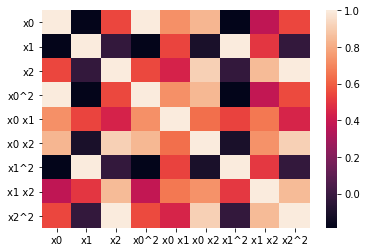

In [25]:
%matplotlib inline
import seaborn as sns
sns.heatmap(pd.DataFrame(X_poly, columns=poly.get_feature_names()).corr())

In [26]:
pd.DataFrame(X_poly, columns=poly.get_feature_names()).corr()

,x0,x1,x2,x0^2,x0 x1,x0 x2,x1^2,x1 x2,x2^2
x0,1.000000,-0.178532,0.542065,0.999710,0.731002,0.836154,-0.186701,0.373188,0.544065
x1,-0.178532,1.000000,-0.027592,-0.178767,0.540347,-0.104801,0.999473,0.502189,-0.027187
x2,0.542065,-0.027592,1.000000,0.549161,0.443159,0.914041,-0.025158,0.850422,0.999881
x0^2,0.999710,-0.178767,0.549161,1.000000,0.730759,0.840733,-0.186603,0.379204,0.551201
x0 x1,0.731002,0.540347,0.443159,0.730759,1.000000,0.641393,0.533193,0.666114,0.445166
x0 x2,0.836154,-0.104801,0.914041,0.840733,0.641393,1.000000,-0.107150,0.734587,0.914968
x1^2,-0.186701,0.999473,-0.025158,-0.186603,0.533193,-0.107150,1.000000,0.504145,-0.024750
x1 x2,0.373188,0.502189,0.850422,0.379204,0.666114,0.734587,0.504145,1.000000,0.850543
x2^2,0.544065,-0.027187,0.999881,0.551201,0.445166,0.914968,-0.024750,0.850543,1.000000


In [27]:
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)

X_poly = poly.fit_transform(X)
print X_poly.shape

pd.DataFrame(X_poly, columns=poly.get_feature_names()).head()  # x0^2, x1^2, and x2^2 went away as they use repeat variables

(162501, 6)


,x0,x1,x2,x0 x1,x0 x2,x1 x2
0,1502.0,2215.0,2153.0,3326930.0,3233806.0,4768895.0
1,1667.0,2072.0,2047.0,3454024.0,3412349.0,4241384.0
2,1611.0,1957.0,1906.0,3152727.0,3070566.0,3730042.0
3,1601.0,1939.0,1831.0,3104339.0,2931431.0,3550309.0
4,1643.0,1965.0,1879.0,3228495.0,3087197.0,3692235.0


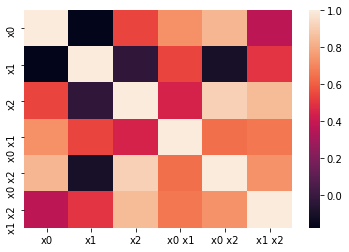

In [28]:
sns.heatmap(pd.DataFrame(X_poly, columns=poly.get_feature_names()).corr())

In [29]:
pd.DataFrame(X_poly, columns=poly.get_feature_names()).corr()  # removes from biases from the correlation matrix

,x0,x1,x2,x0 x1,x0 x2,x1 x2
x0,1.000000,-0.178532,0.542065,0.731002,0.836154,0.373188
x1,-0.178532,1.000000,-0.027592,0.540347,-0.104801,0.502189
x2,0.542065,-0.027592,1.000000,0.443159,0.914041,0.850422
x0 x1,0.731002,0.540347,0.443159,1.000000,0.641393,0.666114
x0 x2,0.836154,-0.104801,0.914041,0.641393,1.000000,0.734587
x1 x2,0.373188,0.502189,0.850422,0.666114,0.734587,1.000000


In [30]:
from sklearn.pipeline import Pipeline

pipe_params = {'poly_features__degree':[1, 2, 3], 'poly_features__interaction_only':[True, False], 'classify__n_neighbors':[3, 4, 5, 6]}

pipe = Pipeline([('poly_features', poly), ('classify', knn)])

grid = GridSearchCV(pipe, pipe_params)
grid.fit(X, y)

print grid.best_score_, grid.best_params_

0.721189408065 {'poly_features__degree': 2, 'poly_features__interaction_only': True, 'classify__n_neighbors': 5}


In [31]:
# best accuracy was 0.720752487677 without constructing polynomial features, so we are able to do better!

In [20]:
#http://thinknook.com/twitter-sentiment-analysis-training-corpus-dataset-2012-09-22/
tweets = pd.read_csv('../data/twitter_sentiment.csv', encoding='latin1')

In [21]:
tweets.head()

,ItemID,Sentiment,SentimentText
0,1,0,is so sad for my APL frie...
1,2,0,I missed the New Moon trail...
2,3,1,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,i think mi bf is cheating on me!!! ...


In [22]:
del tweets['ItemID']

In [23]:
tweets.head()

,Sentiment,SentimentText
0,0,is so sad for my APL frie...
1,0,I missed the New Moon trail...
2,1,omg its already 7:30 :O
3,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,0,i think mi bf is cheating on me!!! ...


In [24]:
X = tweets['SentimentText']
y = tweets['Sentiment']

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

In [26]:
vect = CountVectorizer()
_ = vect.fit_transform(X)
print _.shape

(99989, 105849)


In [27]:
vect = CountVectorizer(stop_words='english')  # removes a set of english stop words (if, a, the, etc)
_ = vect.fit_transform(X)
print _.shape

(99989, 105545)


In [28]:
vect.get_stop_words()

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides'

In [29]:
vect = CountVectorizer(min_df=.05)  # only includes words that occur in at least 5% of the corpus documents
# used to skim the number of features
_ = vect.fit_transform(X)
print _.shape

(99989, 31)


In [30]:
vect = CountVectorizer(max_df=.8)  # only includes words that occur at most 80% of the documents
# used to "Deduce" stop words
_ = vect.fit_transform(X)
print _.shape

(99989, 105849)


In [31]:
vect = CountVectorizer(ngram_range=(1, 5))  # also includes phrases up to 5 words
_ = vect.fit_transform(X)
print _.shape  # explodes the number of features

(99989, 3219557)


In [32]:
vect.get_feature_names()[:15]

[u'00',
 u'00 01',
 u'00 01 minute',
 u'00 01 minute after',
 u'00 01 minute after applications',
 u'00 10',
 u'00 10 00',
 u'00 56',
 u'00 56 03',
 u'00 56 03 beating',
 u'00 56 03 beating my',
 u'00 always',
 u'00 always have',
 u'00 always have such',
 u'00 always have such warmth']

In [33]:
vect = CountVectorizer(lowercase=True)  # lower cases everything first
_ = vect.fit_transform(X)
print _.shape  # features stays the same

(99989, 105849)


In [34]:
vect = CountVectorizer(max_features=1000)  # hard limits the features  based on max counts
_ = vect.fit_transform(X)
print _.shape

(99989, 1000)


In [35]:
vect = CountVectorizer(analyzer='word')  # default analyzer, decides to split into words
_ = vect.fit_transform(X)
print _.shape  

(99989, 105849)


In [36]:
vect = CountVectorizer(analyzer='char')  # used characters
_ = vect.fit_transform(X)
print _.shape  

(99989, 153)


In [37]:
vect.get_feature_names()[:10]

[u'\t', u'\n', u' ', u'!', u'"', u'#', u'$', u'%', u'&', u"'"]

In [38]:
vect = CountVectorizer(analyzer='char_wb')  # uses characters again but only those are aren't at the beginning or ends of words
# wb stands for word boudnaries
_ = vect.fit_transform(X)
print _.shape  

(99989, 149)


In [39]:
# making a custom analyzer

In [40]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')

In [41]:
stemmer.stem('hello')

u'hello'

In [42]:
stemmer.stem('interesting')

u'interest'

In [43]:
stemmer.stem('interesting') == stemmer.stem('interest')

True

In [44]:
# define a function that accepts text and returns a list of lemmas
def word_tokenize(text, how='lemma'):
    words = text.split(' ')  # tokenize into words
    return [stemmer.stem(word) for word in words]

In [45]:
word_tokenize("hello you are very interesting")

[u'hello', u'you', u'are', u'veri', u'interest']

In [46]:
vect = CountVectorizer(analyzer=word_tokenize)
_ = vect.fit_transform(X)
print _.shape  # fewer features as stemming makes words smaller

(99989, 154397)


In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer

vect = CountVectorizer()
_ = vect.fit_transform(X)
print _.shape, _[0,:].mean()

vect = TfidfVectorizer()
_ = vect.fit_transform(X)
print _.shape, _[0,:].mean()  # same number of rows and columns, different cell values

(99989, 105849) 6.61319426731e-05
(99989, 105849) 2.18630609758e-05


In [47]:
# Now let's try some machine learning

In [49]:
# get the null accuracy
y.value_counts(normalize=True)  # 0.56463

1    0.564632
0    0.435368
Name: Sentiment, dtype: float64

In [50]:
from sklearn.naive_bayes import MultinomialNB  # for faster predictions with large number of features...

In [64]:
# set our pipeline parameters
pipe_params = {'vect__ngram_range':[(1, 1), (1, 2)], 'vect__max_features':[1000, 10000], 'vect__stop_words':[None, 'english']}

# instantiate our pipeline
pipe = Pipeline([('vect', CountVectorizer()), ('classify', MultinomialNB())])

# instantiate our gridsearch object
grid = GridSearchCV(pipe, pipe_params)
# fit the gridsearch object
grid.fit(X, y)

# get our results
print grid.best_score_, grid.best_params_

0.755753132845 {'vect__ngram_range': (1, 2), 'vect__stop_words': None, 'vect__max_features': 10000}


In [65]:
from sklearn.pipeline import FeatureUnion

# build a separate featurizer object
featurizer = FeatureUnion([('tfidf_vect', TfidfVectorizer()), ('count_vect', CountVectorizer())])

In [66]:
_ = featurizer.fit_transform(X)
print _.shape  # same number of rows , but twice as many columns as either CV or TFIDF

(99989, 211698)


In [72]:
featurizer.set_params(tfidf_vect__max_features=100, 
                      count_vect__ngram_range=(1, 2), 
                      count_vect__max_features=300)
# the TfidfVectorizer will only keep 100 words while the CountVectorizer will keep 300 of 1 and 2 word phrases
_ = featurizer.fit_transform(X)
print _.shape  # same number of rows , but twice as many columns as either CV or TFIDF

(99989, 400)


In [67]:
pipe_params = {'featurizer__count_vect__ngram_range':[(1, 1), (1, 2)], 'featurizer__count_vect__max_features':[1000, 10000], 'featurizer__count_vect__stop_words':[None, 'english'],
              'featurizer__tfidf_vect__ngram_range':[(1, 1), (1, 2)], 'featurizer__tfidf_vect__max_features':[1000, 10000], 'featurizer__tfidf_vect__stop_words':[None, 'english']}


pipe = Pipeline([('featurizer', featurizer), ('classify', MultinomialNB())])

grid = GridSearchCV(pipe, pipe_params)
grid.fit(X, y)

print grid.best_score_, grid.best_params_

0.758433427677 {'featurizer__tfidf_vect__max_features': 10000, 'featurizer__tfidf_vect__stop_words': 'english', 'featurizer__count_vect__stop_words': None, 'featurizer__count_vect__ngram_range': (1, 2), 'featurizer__count_vect__max_features': 10000, 'featurizer__tfidf_vect__ngram_range': (1, 1)}
